In [ ]:
import os 

os.chdir("..")

# print(os.getcwd())

# Load UMA Calculator

In [2]:
from pathlib import Path
from omegaconf import OmegaConf

from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit
from fairchem.core.units.mlip_unit.api.inference import InferenceSettings

# Load UMA model and set up predictor
uma_model_dir = Path("UMA/")
checkpoint_path = uma_model_dir / "uma-s-1p1.pt"
atomic_refs_path = uma_model_dir / "iso_atom_elem_refs.yaml"
settings = InferenceSettings(
    tf32=False, # torch tf32 format for matrix multiplication, speed up with precision loss
    activation_checkpointing=False, # for large systems, save memory
    merge_mole=False, # for system composition stays the same
    compile=False, # torch compile, buggy sometimes
    external_graph_gen=False, # whether use external graph generator
    internal_graph_gen_version=2,
)
atom_refs = OmegaConf.load(atomic_refs_path)
predictor = load_predict_unit(
    checkpoint_path, device="cuda", atom_refs=atom_refs, inference_settings=settings
)
calculator = FAIRChemCalculator(predictor, task_name="oc20")

# Comparison of DBCata and SOTA MLIP (UMA-S-1.1)

In [3]:
from pathlib import Path
import pickle

import torch
from tqdm import tqdm
from ase.optimize import LBFGS
from ase import Atoms
from ase.constraints import FixAtoms

from trainer.pl_cart import pl_module_cart
from model import InferenceModel, calc_dmae_mic
from model.net import AdsPaiNN

# Test data
stage = 'val'
data_path = Path("data/cathub/") / f"{stage}.pkl"
data_list = pickle.load(open(data_path, 'rb'))
data_list = data_list[-1000:] # Use a subset of test data for a quick view 

# Load DBCata model
batch_size = 512
model_path = 'checkpoints/scorenet-epoch=999-avg_val_loss=0.047.ckpt'
torch.serialization.add_safe_globals([AdsPaiNN])
model = pl_module_cart.load_from_checkpoint(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference_model = InferenceModel(model, data_list, batch_size, device)

# ODE sampling 
steps = 20
eta = 0.0
dbcata_gs = inference_model.inference(steps, eta, device)
inference_model.process_dataloader(dbcata_gs)
inference_model.compute_dmae_mic_results()

# MLIP UMA optimisation 
DMAE = []
uma_opted = []
error = 0

for idx, data in tqdm(enumerate(data_list), total=len(data_list), desc="UMA Optimization"):
    atomic_numbers = data.atomic_numbers.numpy()
    cell = data.cell.squeeze().numpy()
    positions = data.pos.numpy()
    fixed = torch.where(data.fixed != 0)[0].numpy()

    slab = Atoms(numbers=atomic_numbers, cell=cell, positions=positions, pbc=True)
    constraint = FixAtoms(indices=fixed)
    slab.set_constraint(constraint)
    slab.calc = calculator 

    dyn = LBFGS(slab, logfile=None)
    try:
        dyn.run(0.05, 500)
        
        pos1 = torch.matmul(data.pos_relaxed, data.cell.squeeze().inverse())
        pos2 = torch.matmul(
            torch.tensor(slab.positions, dtype=torch.float32), data.cell.squeeze().inverse()
        )
        DMAE.append(calc_dmae_mic(pos1, pos2, data.cell.squeeze()).item())
        
        data_item = data
        data_item.pos_relaxed = torch.tensor(slab.positions, dtype=torch.float32)
        uma_opted.append(data_item)
    except Exception as e:
        print(e)
        error += 1
        
        pos1 = torch.matmul(data.pos_relaxed, data.cell.squeeze().inverse())
        pos2 = torch.matmul(
            data.pos, data.cell.squeeze().inverse()
        )
        DMAE.append(calc_dmae_mic(pos1, pos2, data.cell.squeeze()).item())
        
        # If optimization fails, use original positions
        data_item = data
        data_item.pos_relaxed = data.pos
        uma_opted.append(data_item)
        
        continue

print(f"UMA optimization failed for {error} structures out of {len(data_list)}")
average_dmae = sum(DMAE) / len(DMAE)
print(f"Average DMAE of UMA optimization: {average_dmae} Å")

Inferencing BBDM: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


========================Inference Results============================
Inference time: 0h 0m 2.55s for 20 steps BBDM with eta 0.0
END with totol data length: 1000, error: 0
==============================END====================================


Computing D-MAE of inference results: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


==========================DMAE Results===============================
D-MAE mean: 0.03363836326252552
==============================END====================================


UMA Optimization: 100%|██████████| 1000/1000 [24:38<00:00,  1.48s/it] 

UMA optimization failed for 0 structures out of 1000
Average DMAE of UMA optimization: 0.10631346221470749 Å


In [4]:
from ase import Atoms
from tqdm import tqdm
import numpy as np

dft_energies = np.zeros(len(dbcata_gs))
uma_energies = np.zeros(len(dbcata_gs))
dbcata_energies = np.zeros(len(dbcata_gs))


for idx, data in tqdm(enumerate(dbcata_gs), total=len(dbcata_gs)):
    pos1 = data['pos_relaxed'] # DFT relaxed
    pos2 = data['pos_generated'] # DBCata generated
    pos3 = uma_opted[idx]['pos_relaxed'] # UMA optimized
    cell = data['cell']
    
    atoms_dft = Atoms(
        numbers=data['atomic_numbers'],
        positions=pos1,
        cell=cell.squeeze(),
        pbc=True
    )
    
    atoms_dbcata = Atoms(
        numbers=data['atomic_numbers'],
        positions=pos2,
        cell=cell.squeeze(),
        pbc=True
    )
    
    atoms_uma = Atoms(
        numbers=data['atomic_numbers'],
        positions=pos3,
        cell=cell.squeeze(),
        pbc=True
    )
    
    atoms_dft.calc = calculator
    atoms_dbcata.calc = calculator
    atoms_uma.calc = calculator
    
    energy1 = atoms_dft.get_potential_energy()
    energy2 = atoms_dbcata.get_potential_energy()
    energy3 = atoms_uma.get_potential_energy()
    
    dft_energies[idx] = energy1
    dbcata_energies[idx] = energy2
    uma_energies[idx] = energy3

100%|██████████| 1000/1000 [00:50<00:00, 19.61it/s]


In [5]:
uma_errors = np.abs(uma_energies - dft_energies)
dbcata_errors = np.abs(dbcata_energies - dft_energies)
print(f"Average DFT-UMA energy error: {np.mean(uma_errors)} eV")
print(f"Average DFT-DBCata energy error: {np.mean(dbcata_errors)} eV")
# median errors
print(f"Median DFT-UMA energy error: {np.median(uma_errors)} eV")
print(f"Median DFT-DBCata energy error: {np.median(dbcata_errors)} eV")
# SR (0.1 eV)
uma_sr = np.sum(uma_errors < 0.1) / len(uma_errors)
dbcata_sr = np.sum(dbcata_errors < 0.1) / len(dbcata_errors)
print(f"UMA energy SR (0.1 eV): {uma_sr}")
print(f"DBCata energy SR (0.1 eV): {dbcata_sr}")

Average DFT-UMA energy error: 0.8287331761717797 eV
Average DFT-DBCata energy error: 0.08984630418661982 eV
Median DFT-UMA energy error: 0.01918613910675049 eV
Median DFT-DBCata energy error: 0.006774425506591797 eV
UMA energy SR (0.1 eV): 0.696
DBCata energy SR (0.1 eV): 0.853


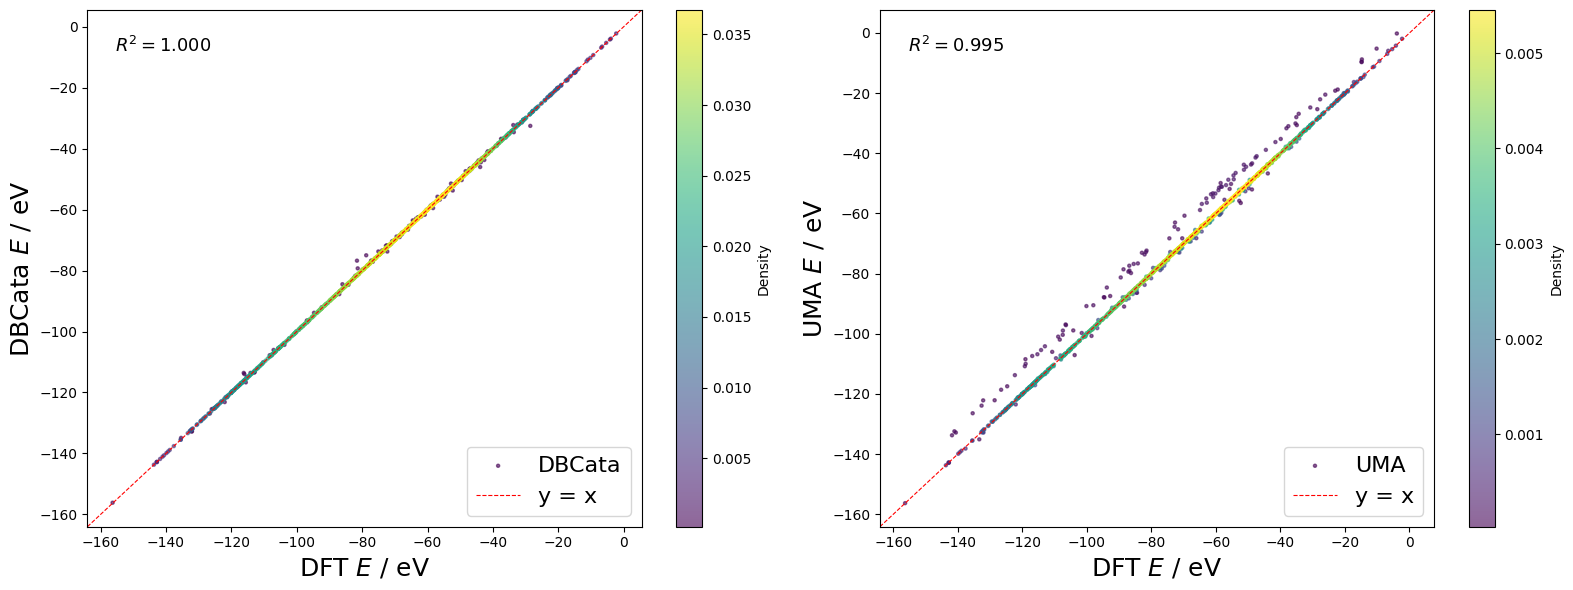

In [6]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize

y1 = dft_energies  
y_hat1 = dbcata_energies

y2 = dft_energies
y_hat2 = uma_energies

plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def plot_density_scatter(ax, y, y_hat, title_label, x_label, y_label):
    correlation_matrix = np.corrcoef(y, y_hat)
    correlation_xy = correlation_matrix[0, 1]
    r_2 = correlation_xy ** 2

    xy = np.vstack([y, y_hat])
    z = gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    y, y_hat, z = y[idx], y_hat[idx], z[idx]

    sc = ax.scatter(y, y_hat, c=z, s=5, cmap='viridis', alpha=0.6,
                     label=title_label)
    

    cbar = plt.colorbar(sc, ax=ax, label='Density')
    
    ax.autoscale(False) 
    data_min = min(y.min(), y_hat.min())
    data_max = max(y.max(), y_hat.max())
    
    span = data_max - data_min
    if span == 0: span = 1 
    
    view_min = data_min - 0.05 * span
    view_max = data_max + 0.05 * span
    
    ax.set_xlim(view_min, view_max)
    ax.set_ylim(view_min, view_max)

    ax.plot(
        [view_min, view_max], [view_min, view_max], '--', color='red', label='y = x', linewidth=0.8
    )
    
    ax.text(0.05, 0.95, f'$R^2 = {r_2:.3f}$', 
             transform=ax.transAxes, 
             fontsize=13, 
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.legend(loc='lower right', fontsize=16)

plot_density_scatter(
    ax=axes[0], 
    y=y1, 
    y_hat=y_hat1, 
    title_label='DBCata', 
    x_label=r'DFT $E$ / eV', 
    y_label=r'DBCata $E$ / eV'
)

plot_density_scatter(
    ax=axes[1], 
    y=y2, 
    y_hat=y_hat2, 
    title_label='UMA', 
    x_label=r'DFT $E$ / eV',               
    y_label=r'UMA $E$ / eV'        
)

plt.tight_layout()
plt.show()

# Post-relaxation with MLIP

In [9]:
print(f"DBCata energy SR (0.1 eV): {dbcata_sr}\n")

dbcata_uma_energies = np.zeros(len(dbcata_gs))

error = 0
for idx, data in tqdm(enumerate(dbcata_gs), total=len(dbcata_gs), desc="Post-relaxation with MLIP"):
    atomic_numbers = data.atomic_numbers.numpy()
    cell = data.cell.squeeze().numpy()
    positions = data.pos_generated.numpy()
    fixed = torch.where(data.fixed != 0)[0].numpy()

    slab = Atoms(numbers=atomic_numbers, cell=cell, positions=positions, pbc=True)
    constraint = FixAtoms(indices=fixed)
    slab.set_constraint(constraint)
    slab.calc = calculator 

    dyn = LBFGS(slab, logfile=None)
    try:
        dyn.run(0.02, 10)
        
        pos1 = torch.matmul(data.pos_relaxed, data.cell.squeeze().inverse())
        pos2 = torch.matmul(
            torch.tensor(slab.positions, dtype=torch.float32), data.cell.squeeze().inverse()
        )
        DMAE.append(calc_dmae_mic(pos1, pos2, data.cell.squeeze()).item())
        
        dbcata_uma_energies[idx] = torch.tensor(slab.get_potential_energy()).item()
    except Exception as e:
        print(e)
        error += 1
        
        pos1 = torch.matmul(data.pos_relaxed, data.cell.squeeze().inverse())
        pos2 = torch.matmul(
            data.pos, data.cell.squeeze().inverse()
        )
        dbcata_uma_energies[idx] = torch.tensor(slab.get_potential_energy()).item()
        
        continue

print(f"Post-MLIP optimization failed for {error} structures out of {len(dbcata_gs)}")

# SR 
uma_errors = np.abs(dbcata_uma_energies - dft_energies)
uma_sr = np.sum(uma_errors < 0.1) / len(uma_errors)
print(f"DBCata + Post-MLIP energy SR (0.1 eV): {uma_sr}")

DBCata energy SR (0.1 eV): 0.853



Post-relaxation with MLIP: 100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]

Post-MLIP optimization failed for 0 structures out of 1000
DBCata + Post-MLIP energy SR (0.1 eV): 0.887
